<h2><font color="#000000" size=6>Minería de datos</font></h2>
<h1><font color="#000000" size=5>PEC 4 - Random Forest</font></h1>
<br><br>
<div style="text-align: right">
<font color="#000000" size=3>Estudiante: Fernando H. Nasser-Eddine López</font><br>
<font color="#000000" size=3>Máster Universitario en Investigación en Inteligencia Artificial (MUIIA)</font><br>
<font color="#000000" size=3>Mayo 2025</font><br>
</div>

<h2><font color="#000000" size=5>Índice</font></h2><a id="indice"></a>

* [Extra: Explicabilidad e interpretabilidad en Bagging](#extra)
    * [E.1. Introducción a la explicabilidad en modelos ensemble](#sectionE1)
    * [E.2 Selección de la técnica de explicabilidad](#sectionE2)
    * [E.3 Selección del modelo a explicar](#sectionE3)
    * [E.4. Implementación de técnicas de explicabilidad](#sectionE4)
        * [E.2.1 Valores SHAP para interpretación global y local](#sectionE41)
        * [E.4.2 Gráficos SHAP para extra trees](#sectionE42)

# <font color="#000000">Extra: Explicabilidad e interpretabilidad en Bagging</font><a id="sectionE"></a>

### <font color="#000000">Importación de librerías</font><a id="section11"></a>


En esta sección realizamos la importación de todas las librerías que utilizaremos a lo largo del análisis. Principalmente, usamos pandas para la manipulación de datos, matplotlib y seaborn para visualizaciones, así como scikit-learn para los algoritmos de aprendizaje automático y evaluación de modelos.

In [1]:
# Importación de las librerías necesarias
import time
import warnings
import os
import pickle

import nbimporter
from a_analisis import detect_outliers_comprehensive

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            confusion_matrix, roc_auc_score, classification_report, 
                            roc_curve, auc)

# Modelos base
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Modelos ensemble
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier)

# Explicabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Evitar warnings innecesarios
warnings.filterwarnings('ignore')

# Crear directorio para las salidas de explicabilidad
output_dir = 'results/explicabilidad'
os.makedirs(output_dir, exist_ok=True)

%matplotlib inline

RANDOM_STATE = 42

In [2]:
# Cargar modelos optimizados y datos necesarios
print("Cargando modelos optimizados y datos para la fase de explicabilidad...")

try:
    with open('data/optimizados/modelos_optimizados.pkl', 'rb') as f:
        optimized_data = pickle.load(f)
    
    # Extraer modelos
    best_rf = optimized_data['random_forest']
    best_et = optimized_data['extra_trees']
    best_bagging_lr = optimized_data['bagging_lr']
    
    # Extraer datos
    X_train_model = optimized_data['X_train']
    X_test_model = optimized_data['X_test']
    y_train_model = optimized_data['y_train']
    y_test_model = optimized_data['y_test']
    
    print("Modelos optimizados y datos cargados correctamente.")
    print(f"Características disponibles: {X_train_model.shape[1]}")
    print(f"Muestras de entrenamiento: {X_train_model.shape[0]}")
    print(f"Muestras de prueba: {X_test_model.shape[0]}")
    
except FileNotFoundError:
    print("Error: No se encuentra el archivo con los modelos optimizados.")

Cargando modelos optimizados y datos para la fase de explicabilidad...
Modelos optimizados y datos cargados correctamente.
Características disponibles: 18
Muestras de entrenamiento: 398
Muestras de prueba: 171


## <font color="#000000">E.1. Introducción a la explicabilidad en modelos ensemble</font><a id="sectionE1"></a>

Los algoritmos ensamble como Random Forest, Extra Trees y Bagging son frecuentemente catalogados como "cajas negras" debido a su complejidad inherente. Sin embargo, esta complejidad no implica necesariamente opacidad total en términos de interpretabilidad. En este apartado, exploramos algunas técnicas para explicar las predicciones de nuestros modelos ensemble, específicamente aplicados al conjunto de datos de cáncer de mama de Wisconsin.
La explicabilidad resulta importante en contextos médicos como el diagnóstico de cáncer, donde comprender el razonamiento detrás de una predicción puede ser tan importante como la precisión de la misma. Técnicas como SHAP (SHapley Additive exPlanations) y LIME (Local Interpretable Model-agnostic Explanations) nos permiten examinar qué características influyen en la clasificación de un tumor como benigno o maligno, proporcionando transparencia al proceso de decisión.

## <font color="#000000">E.2 Selección de la técnica de explicabilidad</font><a id="sectionE2"></a>

Para este análisis de explicabilidad se ha seleccionado **SHAP (SHapley Additive exPlanations)** entre las diferentes técnicas disponibles (SHAP, LIME u otras). Esta elección se fundamenta en las siguientes razones:

1. **Fundamento teórico riguroso**: SHAP se basa en los valores Shapley de la teoría de juegos cooperativos, lo que proporciona garantías matemáticas de equidad y consistencia en la atribución de importancia a las características.
2. **Eficiencia computacional para modelos basados en árboles**: La implementación TreeSHAP está optimizada específicamente para modelos como Random Forest y Extra Trees, permitiendo cálculos exactos y rápidos.
3. **Capacidad dual local-global**: SHAP permite tanto la interpretación de predicciones individuales (explicabilidad local) como la comprensión del comportamiento general del modelo (explicabilidad global).
4. **Visualizaciones múltiples integradas**: La biblioteca SHAP ofrece diversas visualizaciones especializadas que facilitan la interpretación en diferentes niveles de análisis.
5. **Relevancia en el contexto médico**: En aplicaciones de diagnóstico médico como la detección de cáncer de mama, la rigurosidad y precisión que ofrece SHAP son particularmente importantes para garantizar interpretaciones fiables.

In [3]:
print(f"Versión de SHAP instalada: {shap.__version__}")

Versión de SHAP instalada: 0.47.2


## <font color="#000000">E.3 Selección del modelo a explicar</font><a id="sectionE3"></a>


Si bien se han desarrollado y evaluado varios modelos ensemble (Random Forest, Extra Trees y Bagging con diferentes estimadores base), se ha seleccionado el modelo **Extra Trees** para el análisis de explicabilidad por los siguientes motivos:

1. **Rendimiento superior**: Este modelo alcanzó una precisión del 100% en el conjunto de datos de prueba tras el preprocesamiento, y mantuvo un excelente rendimiento (97.08%) incluso con los datos originales.
2. **Robustez**: Demostró mayor capacidad para generalizar a través de diferentes conjuntos de datos, lo que sugiere que sus patrones de decisión son más estables.
3. **Representatividad del enfoque ensemble**: Extra Trees ejemplifica perfectamente las ventajas de los métodos ensemble basados en árboles aleatorios, que constituyen el tema central de esta práctica.
4. **Compatibilidad ideal con SHAP**: Como modelo basado en árboles, Extra Trees permite aprovechar al máximo las capacidades de TreeSHAP, obteniendo explicaciones precisas y eficientes.

En las siguientes secciones se implementarán diferentes análisis y visualizaciones SHAP para comprender en profundidad cómo el modelo Extra Trees toma decisiones en la clasificación de tumores mamarios, identificando las características más relevantes y explorando cómo sus valores influyen en las predicciones.

## <font color="#000000">E.4. Implementación de técnicas de explicabilidad</font><a id="sectionE2"></a>

### <font color="#000000">E.4.1 Valores SHAP para interpretación global y local</font><a id="sectionE41"></a>

La técnica SHAP, basada en la teoría de juegos cooperativos, asigna a cada variable un valor que representa su contribución a la predicción final. Esta técnica ofrece dos niveles de análisis: global (importancia general de las variables en el modelo) y local (contribución de cada variable para una predicción específica).

In [4]:
# Inicializar SHAP (usar TreeExplainer para ET)
explainer_et = shap.TreeExplainer(best_et)

# Calcular valores SHAP para los datos de prueba
shap_values_et = explainer_et.shap_values(X_test_model)

### <font color="#000000">E.4.2 Gráficos SHAP para extra trees</font><a id="sectionE42"></a>

#### Gráfico de barras (importancia global de características)

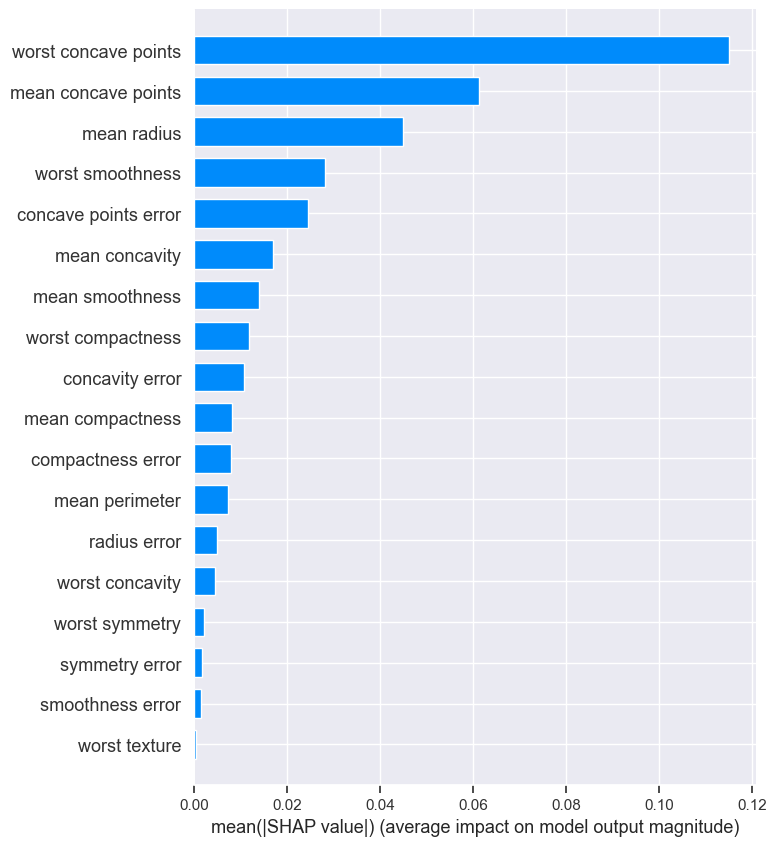

In [14]:
# Crear una figura antes
plt.figure(figsize=(10, 8))

# Generar el gráfico SHAP sin mostrarlo
shap.summary_plot(shap_values_et[:, :, 1], X_test_model, plot_type='bar', show=False)

# Guardar la figura en el directorio especificado
plt.savefig(f'{output_dir}/shap_feature_importance.png', dpi=100, bbox_inches='tight')


plt.show()

1. **Coincidencia con Random Forest y Extra Trees**: En ambos métodos, "worst concave points" y "mean concave points" ocupaban también las primeras posiciones. Según el análisis previo: "Ambos algoritmos coinciden en posicionar variables relacionadas con los puntos cóncavos en los primeros lugares, intercambiando solo las posiciones 1 y 2".
2. **Concordancia con ANOVA F-value**: El método F-value también identificaba "worst concave points" y "mean concave points" como las variables con mayor poder discriminativo (valores F de 732.28 y 635.03 respectivamente).
3. **Alineación con Información Mutua**: El análisis de información mutua señalaba igualmente estas dos variables como las más relevantes, con valores muy superiores (0.452 y 0.432) al resto.

#### Gráfico resumen (global con puntos individuales)

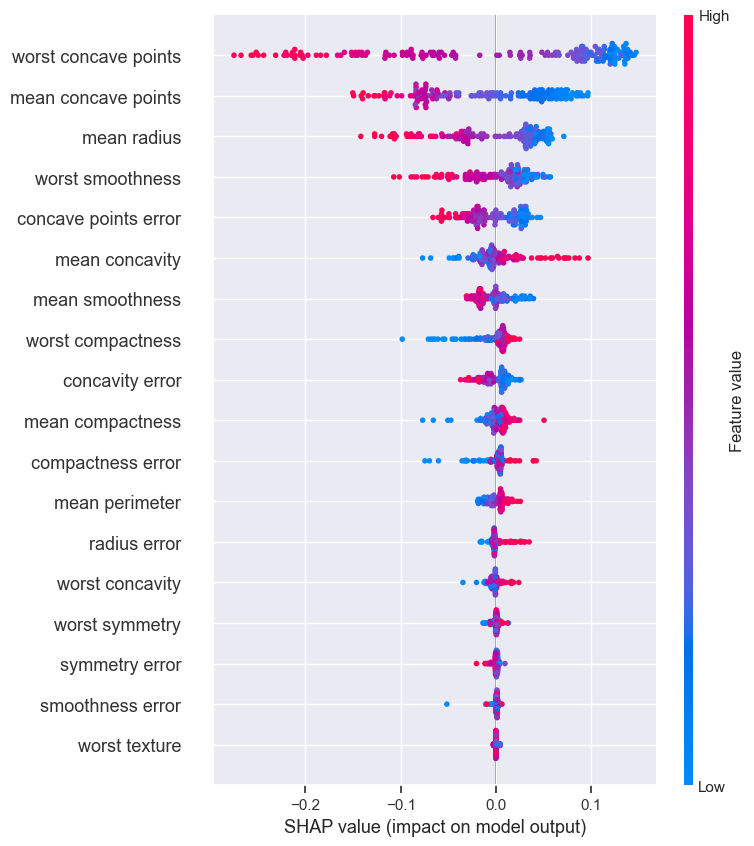

In [6]:
# Crear una figura antes
plt.figure(figsize=(10, 8))

# Generar el gráfico SHAP sin mostrarlo inmediatamente
shap.summary_plot(shap_values_et[:, :, 1], X_test_model, show=False)

# Guardar la figura actual
plt.savefig(f'{output_dir}/shap_individual_importance.png', dpi=100, bbox_inches='tight')

# Ahora mostrar el gráfico
plt.show()

El gráfico muestra la distribución de los valores SHAP para cada característica del modelo Extra Trees optimizado, proporcionando una visión detallada de cómo los distintos valores de cada variable afectan las predicciones del modelo.

Este gráfico de resumen SHAP complementa el anterior de importancia global y añade dos dimensiones críticas:

1. **Dirección del impacto**: Valores SHAP positivos (hacia la derecha) aumentan la probabilidad de clasificar un tumor como benigno, mientras que valores negativos (hacia la izquierda) impulsan la predicción hacia maligno.
2. **Distribución de valores**: Cada punto representa una muestra del conjunto de datos de prueba. Su posición horizontal indica el impacto de esa característica en esa muestra específica.
3. **Coloración por valor**: El color de cada punto indica si el valor de la característica es alto (rojo) o bajo (azul) en esa muestra.

**Variables donde valores altos (rojos) tienden a predecir malignidad (izquierda)**

1. **worst concave points**: Los puntos rojos (valores altos) se concentran claramente hacia la izquierda, indicando fuerte predicción de malignidad.
2. **mean concave points**: Similar al anterior, con valores altos (rojos) predominantemente hacia la izquierda (malignidad).
3. **mean radius**: Los valores altos (rojos) se agrupan hacia la izquierda, asociándose con malignidad.
4. **worst smoothness**: Los valores altos tienden a concentrarse hacia la izquierda, aunque con menor separación que las primeras variables.
5. **concave points error**: Los valores altos también tienden hacia la izquierda (malignidad).
6. **mean concavity**: Valores altos aparecen principalmente hacia la izquierda, aunque con alguna dispersión.
7. **mean smoothness**: Valores altos (rojos) generalmente hacia la izquierda.
8. **concavity error**: Valores altos hacia la izquierda, aunque con menor intensidad que otras variables.
9. **symmetry error**: Valores altos ligeramente orientados hacia la izquierda.
10. **smoothness error**: Valores altos ligeramente hacia la izquierda, aunque con poca separación.

**Variables donde valores altos (rojos) tienden a predecir benignidad (derecha)**

1. **worst compactness**: Los valores altos (rojos) aparecen predominantemente hacia la derecha (benignidad).
2. **mean compactness**: Similar al anterior, con valores altos hacia la derecha.
3. **compactness error**: Valores altos principalmente hacia la derecha.
4. **mean perimeter**: Valores altos tienden hacia la derecha, aunque con menor separación.
5. **radius error**: Valores altos hacia la derecha (benignidad).
6. **worst concavity**: Valores altos ligeramente hacia la derecha.
7. **worst symmetry**: Valores altos generalmente hacia la derecha.
8. **worst texture**: Poca separación pero valores altos ligeramente hacia la derecha.

#### Conexión entre el análisis SHAP y el análisis anterior

El análisis SHAP de la distribución de impactos individuales refuerza y amplía los hallazgos que obtuvimos en las fases previas del proyecto, proporcionando una comprensión más profunda y matizada.

**Concordancia con el análisis exploratorio inicial**

En la fase de análisis exploratorio (Sección 1), identificamos que:

1. **Diferencias entre clases**: "Los tumores malignos tienden a presentar valores más altos en muchas características" según se observó en los histogramas y en la Tabla 3. El análisis SHAP confirma esta observación para variables críticas como "worst concave points", "mean concave points" y "mean radius", donde efectivamente valores altos (rojos) contribuyen a la predicción de malignidad.
2. **Variables con mayor diferencia relativa**: En la Figura 1, identificamos que "mean concavity", "area error" y "mean concave points" presentaban las mayores diferencias relativas entre clases. El análisis SHAP refuerza la importancia de "mean concave points" y "mean concavity", aunque posiciona "worst concave points" como la característica más influyente, lo que sugiere que el valor máximo de puntos cóncavos es aún más discriminativo que el promedio.
3. **Variables correlacionadas**: En la Figura 9 (mapa de calor) y Tabla 5 identificamos grupos de variables altamente correlacionadas. El análisis SHAP muestra comportamientos similares para variables correlacionadas como "worst concave points" y "mean concave points", confirmando la redundancia parcial entre estas características.

**Validación de la selección de variables**

En la fase de selección de variables (Sección 2):

1. **Random Forest y Extra Trees**: Ambos algoritmos posicionaron "worst concave points" y "mean concave points" en los primeros lugares de importancia. El análisis SHAP valida completamente esta jerarquía, mostrando precisamente estas dos variables como las más influyentes y con el mismo ordenamiento.
2. **Clustering de variables**: En la Tabla 2.10 agrupamos las variables en clusters. El comportamiento similar que observamos en el gráfico SHAP para variables del mismo cluster (como las medidas de concavidad) confirma la eficacia de ese agrupamiento.
3. **ANOVA F y Mutual Information**: Estos métodos también identificaron "worst concave points" (F-value: 732.28) y "mean concave points" (F-value: 635.03) como las variables más discriminativas. El análisis SHAP no solo confirma esta jerarquía, sino que además visualiza cómo contribuyen estas variables a la clasificación.

**Comprensión ampliada del modelo optimizado**

En la fase de modelado y optimización (Secciones 3 y 4):

1. **Rendimiento del modelo Extra Trees**: Nuestro modelo optimizado alcanzó una exactitud del 100% con apenas 25 árboles y profundidad máxima de 5. El análisis SHAP revela que esta eficiencia se debe a que el modelo captura efectivamente los patrones discriminativos en las variables principales, particularmente las relacionadas con concavidad.
2. **Reducción de complejidad**: Optimizamos el modelo reduciendo su complejidad en un 75%. El análisis SHAP sugiere que esta simplificación fue posible porque unas pocas variables críticas (principalmente "worst concave points", "mean concave points" y "mean radius") proporcionan la mayor parte de la capacidad predictiva.
3. **Direccionalidad del impacto**: Mientras que nuestro análisis previo solo identificaba qué variables eran importantes, el análisis SHAP revela cómo influyen estas variables, mostrando que los valores altos de concavidad y radio contribuyen a predecir malignidad, mientras que valores altos de compacidad favorecen la predicción de benignidad.

#### Gráfico de dependencia (para la característica más importante)

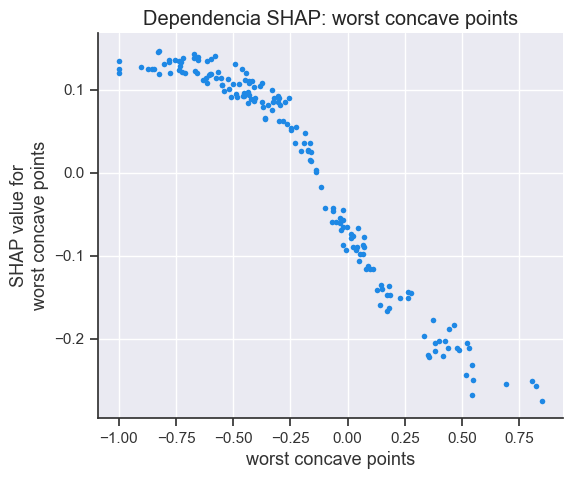

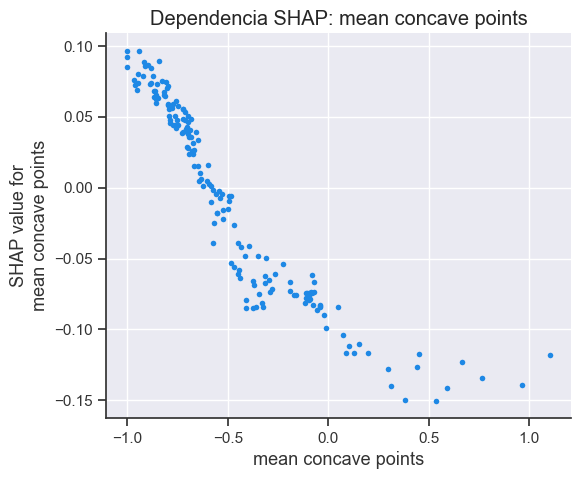

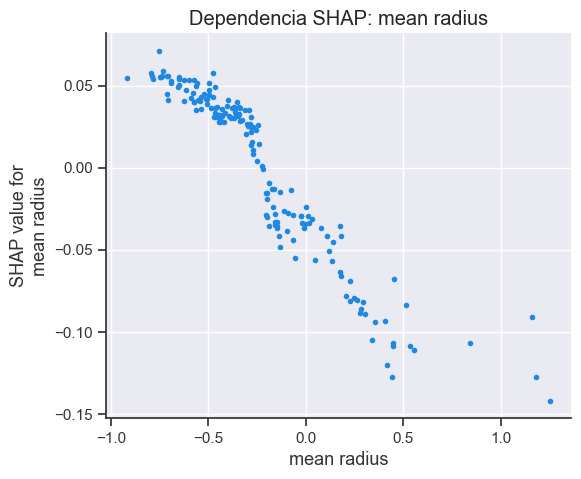

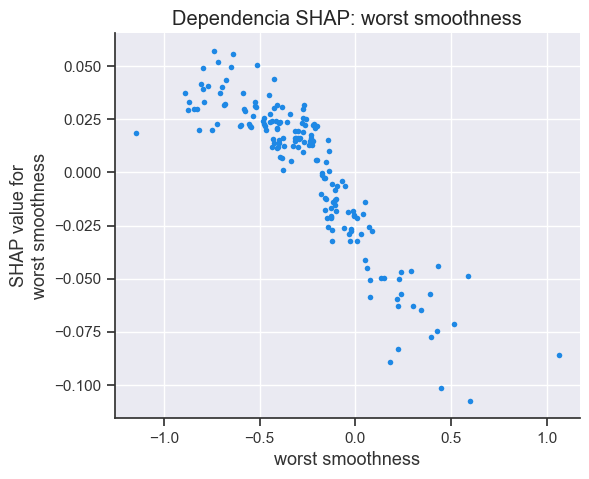

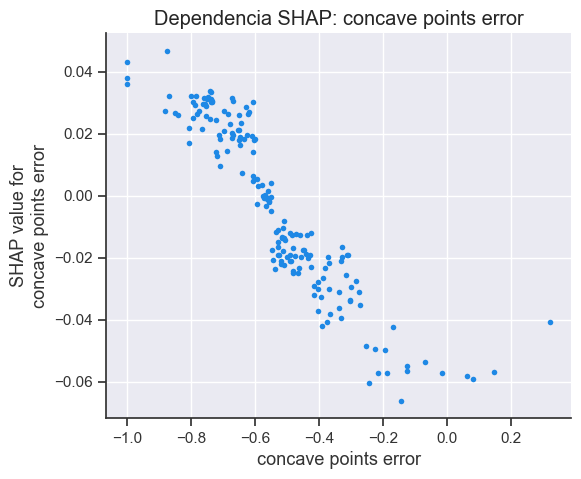

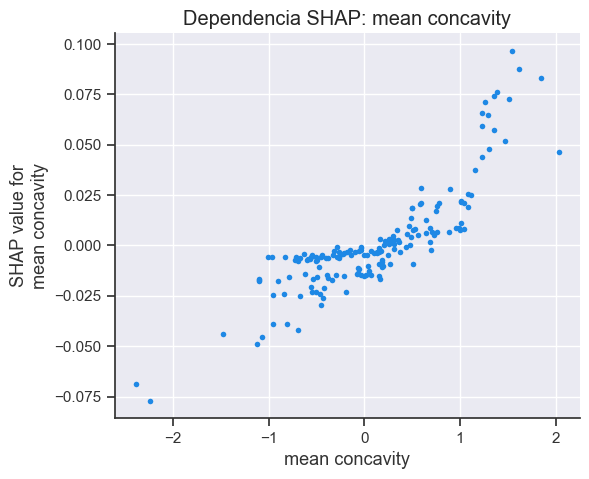

In [7]:
# Seleccionar las variables más importantes según el análisis SHAP
# Ordenar características por importancia (valor SHAP medio absoluto)
mean_shap_values = np.abs(shap_values_et[:, :, 1]).mean(0)
top_indices = np.argsort(-mean_shap_values)[:6]  # Tomamos las 6 más importantes
top_features = X_test_model.columns[top_indices]

# Enfoque alternativo: generar cada gráfico individualmente y luego combinarlos

# 1. Primero, generar y guardar cada gráfico individual
individual_plots = []
for feature in top_features:
    # Crear una nueva figura para cada característica
    # plt.figure(figsize=(8, 6))
    
    # Generar el gráfico de dependencia
    shap.dependence_plot(
        feature, 
        shap_values_et[:, :, 1], 
        X_test_model,
        interaction_index=None,
        show=False
    )
    
    # Añadir título
    plt.title(f'Dependencia SHAP: {feature}')
    
    # Guardar la figura individual
    plot_path = f'{output_dir}/shap_{feature.replace(" ", "_")}.png'
    plt.savefig(plot_path, dpi=100, bbox_inches='tight')
    individual_plots.append(plot_path)
    
    # Mostrar la figura individual
    plt.show()
    plt.close()


**Síntesis de los hallazgos clave**

1. **Patrones de dependencia diversos**: Mientras que algunas características muestran relaciones lineales claras (worst concave points), otras exhiben comportamientos no lineales (mean concavity) o con umbrales (mean radius).
2. **Comportamientos contrastantes**: "mean concavity" muestra un patrón opuesto al de "worst concave points" y "mean concave points" para valores altos. Esto sugiere que el modelo ha capturado matices sutiles entre estas medidas relacionadas pero distintas.
3. **Diferentes niveles de consistencia**: La variación en la dispersión entre gráficos indica que algunas características (como "worst concave points") tienen efectos muy consistentes, mientras que otras (como "worst smoothness") tienen efectos que dependen más del contexto de otras variables.
4. **Umbrales críticos**: Varios gráficos muestran puntos de inflexión o umbrales donde el impacto cambia significativamente, proporcionando información valiosa para posibles puntos de corte diagnósticos.


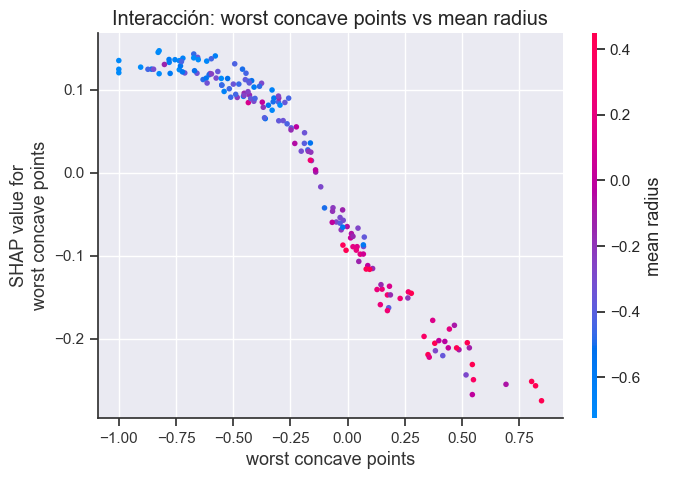

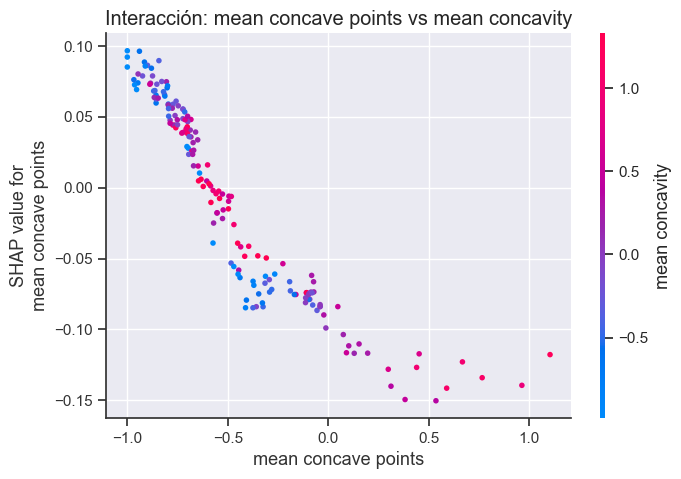

In [8]:
# 2. Generar las interacciones individualmente
# Interacción 1: worst concave points vs mean radius
# plt.figure(figsize=(8, 6))
shap.dependence_plot(
    'worst concave points', 
    shap_values_et[:, :, 1], 
    X_test_model,
    interaction_index='mean radius',
    show=False
)
plt.title('Interacción: worst concave points vs mean radius')
plt.savefig(f'{output_dir}/interaction_worst_concave_points_mean_radius.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Interacción 2: mean concave points vs mean concavity
# plt.figure(figsize=(8, 6))
shap.dependence_plot(
    'mean concave points', 
    shap_values_et[:, :, 1], 
    X_test_model,
    interaction_index='mean concavity',
    show=False
)
plt.title('Interacción: mean concave points vs mean concavity')
plt.savefig(f'{output_dir}/interaction_mean_concave_points_mean_concavity.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
# Instalar PIL si no está disponible
# !pip install Pillow

from PIL import Image
import numpy as np

# Función para crear un grid de imágenes
def create_image_grid(image_paths, rows, cols, output_path):
    # Abrir las imágenes y redimensionarlas si es necesario
    images = [Image.open(img_path) for img_path in image_paths]
    
    # Determinar el tamaño del grid
    width = max(img.width for img in images)
    height = max(img.height for img in images)
    
    # Crear una imagen nueva para el grid
    grid_img = Image.new('RGB', (width * cols, height * rows), color=(255, 255, 255))
    
    # Colocar cada imagen en el grid
    for i, img in enumerate(images):
        if i >= rows * cols:
            break
            
        row = i // cols
        col = i % cols
        
        # Redimensionar si es necesario para mantener uniformidad
        if img.width != width or img.height != height:
            img = img.resize((width, height))
            
        # Pegar la imagen en la posición correspondiente
        grid_img.paste(img, (col * width, row * height))
    
    # Guardar el grid
    grid_img.save(output_path)
    return output_path

# Crear el grid de dependencias
dependency_grid_path = create_image_grid(
    individual_plots,
    rows=2, 
    cols=3, 
    output_path=f'{output_dir}/shap_dependency_grid.png'
)

# Crear el grid de interacciones
interaction_grid_path = create_image_grid(
    [f'{output_dir}/interaction_worst_concave_points_mean_radius.png',
     f'{output_dir}/interaction_mean_concave_points_mean_concavity.png'],
    rows=1, 
    cols=2, 
    output_path=f'{output_dir}/shap_interaction_grid.png'
)

print(f"Grids creados y guardados en:\n{dependency_grid_path}\n{interaction_grid_path}")

Grids creados y guardados en:
results/explicabilidad/shap_dependency_grid.png
results/explicabilidad/shap_interaction_grid.png


#### Gráfico de fuerza local correcto para Random Forest (predicción 0, clase positiva)

Para la selección de casos en nuestro análisis SHAP, implementé una estrategia de muestreo dirigida basada en la confianza de las predicciones del modelo. El objetivo fue obtener una representación completa del comportamiento del modelo, incluyendo casos típicos de cada clase y casos límite más desafiantes.

La selección utilizó tres categorías distintas:

1. **Casos malignos típicos**: 
   - Muestras realmente malignas (etiqueta verdadera = 0)
   - Con alta confianza de predicción (probabilidad < 0.1)
   - Representan casos donde el modelo está muy seguro de la malignidad

2. **Casos benignos típicos**:
   - Muestras realmente benignas (etiqueta verdadera = 1)
   - Con alta confianza de predicción (probabilidad > 0.9)
   - Representan casos donde el modelo está muy seguro de la benignidad

3. **Casos límite o difíciles**:
   - Muestras cuya predicción está cerca del umbral de decisión (probabilidad ≈ 0.5 ± 0.1)
   - Representan casos donde el modelo tiene menor certeza

Para cada categoría, seleccionamos hasta 3 casos aleatoriamente, asegurando que tuviéramos suficientes ejemplos para análisis sin sobrecargar la visualización.

In [10]:
# 1. Gráfico de fuerza global para muestras específicas
# Ya que matplotlib=True no funciona con múltiples muestras, vamos a usar la versión HTML
# y guardarla, o seleccionar algunas muestras representativas

# Selección de casos representativos
# Obtener predicciones
y_pred_prob = best_et.predict_proba(X_test_model)[:, 1]

# Índices de casos típicos y límite
# Tumores malignos típicos (predicción cercana a 0)
malignant_indices = np.where((y_test_model == 0) & (y_pred_prob < 0.1))[0]
malignant_samples = np.random.choice(malignant_indices, min(1, len(malignant_indices)), replace=False)

# Tumores benignos típicos (predicción cercana a 1)
benign_indices = np.where((y_test_model == 1) & (y_pred_prob > 0.9))[0]
benign_samples = np.random.choice(benign_indices, min(1, len(benign_indices)), replace=False)

# Casos límite (predicción cercana a 0.5)
boundary_indices = np.where(np.abs(y_pred_prob - 0.5) < 0.1)[0]
boundary_samples = np.random.choice(boundary_indices, min(1, len(boundary_indices)), replace=False)

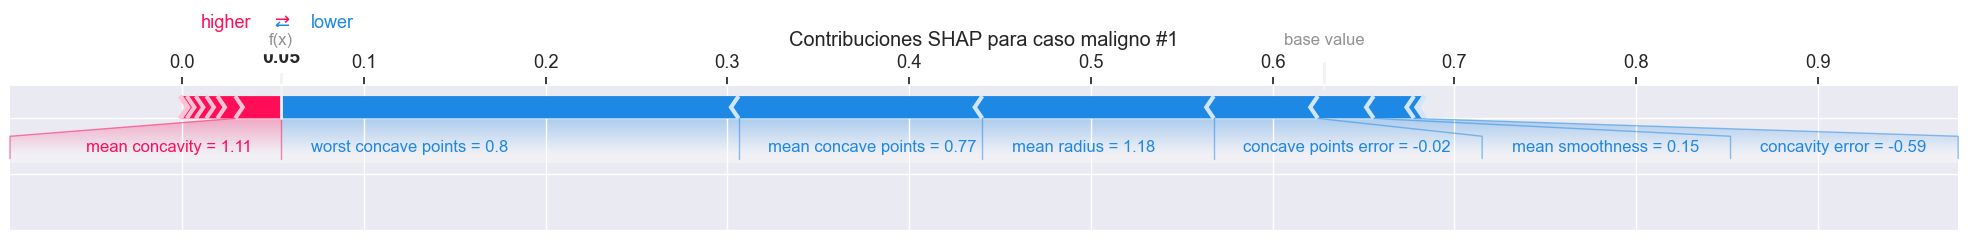

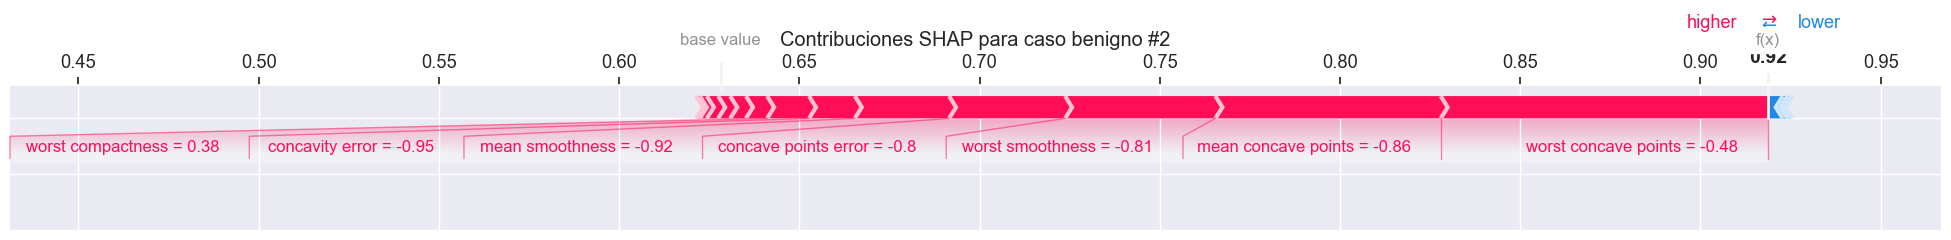

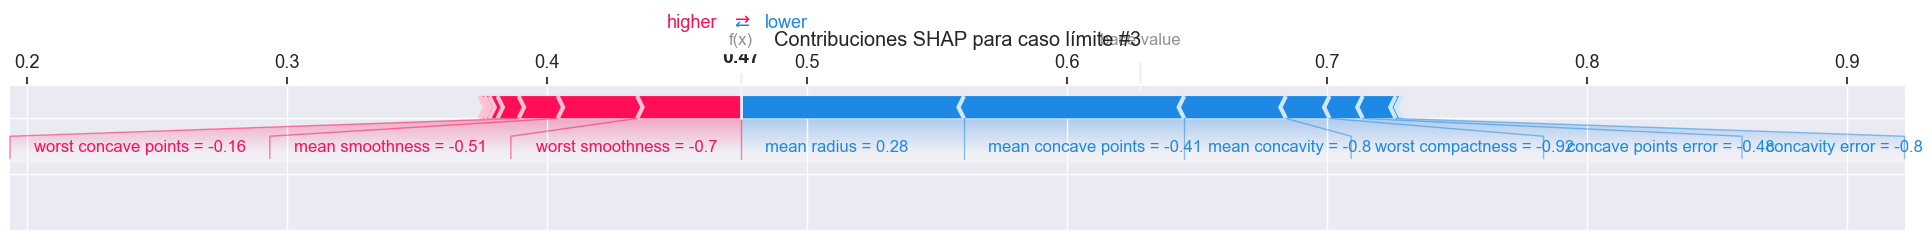

In [11]:
import numpy as np

# Función para redondear los valores de las características antes de pasarlos al gráfico
def round_features_for_display(X, decimals=2):
    """Redondea los valores de las características para mejor visualización"""
    X_rounded = X.copy()
    for col in X_rounded.columns:
        X_rounded[col] = np.round(X_rounded[col], decimals)
    return X_rounded

# Al generar los gráficos de fuerza, usa los valores redondeados solo para visualización
for i, sample_idx in enumerate(np.concatenate([malignant_samples, benign_samples, boundary_samples])):
    sample_type = "maligno" if i < len(malignant_samples) else \
                  "benigno" if i < len(malignant_samples) + len(benign_samples) else "límite"
    
    # Obtenemos los valores reales para el cálculo SHAP
    feature_values = X_test_model.iloc[sample_idx, :]
    
    # Creamos una versión redondeada solo para mostrar
    feature_values_display = round_features_for_display(
        pd.DataFrame(feature_values).T, 
        decimals=2
    )
    
    # plt.figure(figsize=(12, 3))
    shap.force_plot(explainer_et.expected_value[1], 
                    shap_values_et[sample_idx, :, 1], 
                    feature_values_display,  # Usamos la versión redondeada
                    matplotlib=True, 
                    show=False)
    plt.title(f"Contribuciones SHAP para caso {sample_type} #{i%3+1}")
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_force_{sample_type}_{i%3+1}.png', 
                dpi=100, bbox_inches='tight')

    plt.show()
    plt.close()

**Interpretación comparativa de gráficos de fuerza SHAP para tres casos representativos**

Los gráficos de fuerza SHAP presentados muestran cómo diferentes características contribuyen a las predicciones del modelo Extra Trees para tres casos representativos: maligno, benigno y límite. Esta comparación revela patrones distintivos en la toma de decisiones del modelo.

**Caso maligno #1 (gráfico inferior)**

**Predicción final**: f(x) = 0.08 (alta confianza de malignidad)
**Valor base**: Aproximadamente 0.6

**Características clave que empujan hacia malignidad (azul):**
Todas las características mostradas empujan consistentemente la predicción hacia malignidad (valores bajos), sin ninguna característica que contradiga esta tendencia. Los valores altos de medidas relacionadas con concavidad y radio muestran el patrón clásico de células malignas, con núcleos más grandes e irregulares.

**Caso benigno #2 (gráfico superior)**

**Predicción final**: f(x) = 0.92 (alta confianza de benignidad)
**Valor base**: Aproximadamente 0.6

**Características clave que empujan hacia benignidad (rojo):**

En este caso, todas las características muestran valores que empujan fuertemente hacia benignidad (valores altos de predicción). Es notable que las mismas características relacionadas con concavidad que determinan malignidad en el primer caso, aquí muestran valores bajos que indican benignidad. Esto confirma que el modelo ha captado correctamente los patrones morfológicos que diferencian células benignas de malignas.

**Caso límite #3 (gráfico central)**

**Predicción final**: f(x) = 0.45 (cercano al umbral de decisión)
**Valor base**: Aproximadamente 0.6

**Características con influencia mixta:**

Este caso límite presenta un patrón mixto fascinante donde algunas características empujan hacia malignidad mientras otras empujan hacia benignidad, resultando en una predicción cercana al umbral de decisión (0.45). Las medidas de concavidad y puntos cóncavos sugieren malignidad, pero las medidas de compacidad contradicen esta tendencia, empujando hacia benignidad. Esta contradicción explica por qué el modelo muestra incertidumbre en la clasificación.

**Análisis comparativo**

La comparación de estos tres casos revela patrones importantes en la toma de decisiones del modelo:

1. **Consistencia en casos extremos**: Para casos claramente malignos o benignos, las características tienden a empujar coherentemente en la misma dirección, reforzando la confianza de la predicción.

2. **Contradicciones en casos límite**: Los casos cercanos al umbral de decisión muestran características que empujan en direcciones opuestas, representando morfologías celulares con características mixtas de ambas clases.

3. **Variables determinantes**: Las medidas relacionadas con concavidad y puntos cóncavos aparecen consistentemente como determinantes en los tres casos, confirmando su importancia para la clasificación.

4. **Comportamiento de compacidad**: Es notable que las medidas de compacidad (worst compactness, mean compactness) muestran un comportamiento interesante: valores altos favorecen benignidad, mientras que valores bajos son característicos de casos límite.

Esta visualización confirma que el modelo Extra Trees ha capturado relaciones biológicamente relevantes entre las características morfológicas nucleares y la malignidad del tumor. El análisis de casos límite es particularmente valioso, revelando las combinaciones de características que generan mayor incertidumbre en el modelo, lo que podría orientar la investigación hacia marcadores adicionales para mejorar la clasificación de estos casos difíciles.

In [12]:
# Gráfico de decisión para casos individuales con solución para guardar correctamente
for i, sample_idx in enumerate(np.concatenate([malignant_samples, benign_samples, boundary_samples])):
    sample_type = "maligno" if i < len(malignant_samples) else \
                  "benigno" if i < len(malignant_samples) + len(benign_samples) else "límite"
    
    # Crear la figura con tamaño específico
    fig = plt.figure(figsize=(10, 8))
    
    # Generar el gráfico de decisión
    shap.decision_plot(explainer_et.expected_value[1], 
                      shap_values_et[sample_idx:sample_idx+1, :, 1], 
                      X_test_model.iloc[sample_idx:sample_idx+1],
                      feature_order='importance',
                      show=False)  # Importante: show=False
    
    # Añadir título
    plt.title(f"Decisión SHAP para caso {sample_type} #{i%3+1}")
    
    # Ajustar el diseño
    plt.tight_layout()
    
    # Asegurarse de que todas las operaciones de dibujo se completen
    fig.canvas.draw()
    
    # Guardar la figura usando el objeto fig directamente
    fig.savefig(f'{output_dir}/shap_decision_{sample_type}_{i%3+1}.png', 
                dpi=100, bbox_inches='tight')
    
    # Mostrar para verificar
    # plt.show()
    
    # Cerrar explícitamente
    plt.close(fig)

In [13]:
# Crear el grid de interacciones
interaction_grid_path = create_image_grid(
    [f'{output_dir}/shap_force_benigno_2.png',
     f'{output_dir}/shap_force_límite_3.png',
     f'{output_dir}/shap_force_maligno_1.png'],
    rows=3, 
    cols=1, 
    output_path=f'{output_dir}/shap_force_grid.png'
)

# Crear el grid de interacciones
interaction_grid_path = create_image_grid(
    [f'{output_dir}/shap_decision_benigno_2.png',
     f'{output_dir}/shap_decision_límite_3.png',
     f'{output_dir}/shap_decision_maligno_1.png'],
    rows=2, 
    cols=3, 
    output_path=f'{output_dir}/shap_decision_grid.png'
)

print(f"Grids creados y guardados en:\n{dependency_grid_path}\n{interaction_grid_path}")

Grids creados y guardados en:
results/explicabilidad/shap_dependency_grid.png
results/explicabilidad/shap_decision_grid.png
